### Настройки

Начинаем с импорта библиотек

In [ ]:
!pip install psycopg2-binary

In [ ]:
# Устанавливаем squarify для построения TreeMap
!pip install squarify
# Библиотека для пеермещения текствых подписей на графиках
!pip install adjustText
# wordcloud
!pip install wordcloud

In [ ]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
import squarify  # TreeMap
from adjustText import adjust_text
from wordcloud import WordCloud

Создаем соединение с заданными параметрами

In [ ]:
connection = psycopg2.connect(
    dbname=DBNAME,
    user=USER,
    host=HOST,
    password=PASSWORD,
    port=PORT
)

#Предварительный анализ данных

In [ ]:
# Сколько вакансий есть в базе?
query_vacancies = """
SELECT COUNT(*) AS total_vacancies
FROM public.vacancies;
"""

# Сколько работодателей?
query_employers = """
SELECT COUNT(*) AS total_employers
FROM public.employers;
"""

# Сколько регионов?
query_areas = """
SELECT COUNT(*) AS total_areas
FROM public.areas;
"""

# Сколько сфер деятельности?
query_industries = """
SELECT COUNT(*) AS total_industries
FROM public.industries;
"""

df_vacancies = pd.read_sql_query(query_vacancies, connection)
df_employers = pd.read_sql_query(query_employers, connection)
df_areas = pd.read_sql_query(query_areas, connection)
df_industries = pd.read_sql_query(query_industries, connection)

summary = pd.DataFrame({
    'Категория': ['Вакансии', 'Работодатели', 'Регионы', 'Сферы деятельности'],
    'Количество': [
        df_vacancies.iloc[0]['total_vacancies'],
        df_employers.iloc[0]['total_employers'],
        df_areas.iloc[0]['total_areas'],
        df_industries.iloc[0]['total_industries']
    ]
})

summary

/tmp/ipython-input-2546349653.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_vacancies = pd.read_sql_query(query_vacancies, connection)
/tmp/ipython-input-2546349653.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_employers = pd.read_sql_query(query_employers, connection)
/tmp/ipython-input-2546349653.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_areas = pd.read_sql_query(query_areas, connection)
/tmp/ipython-input-2546349653.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/

,Категория,Количество
0,Вакансии,49197
1,Работодатели,23501
2,Регионы,1362
3,Сферы деятельности,294


Для анализа нам предоставлена база вакансий,охватывающая значительную часть рынка (49 197 вакансий х 23 501 работодателя)

Широкая георграфия вакансий - 1 362 региона дает возможность выявить закономерности рынка труда как в крупных мегаполисах, так и в небольших городах и районах.

Широкий спектр предстваленных отраслей (294 сферы) позволит изучить ситуацию по индустриям

In [ ]:
sns.set(style="whitegrid")
plt.rcParams['font.size'] = 10

###Топ-10 регионов по количеству вакансий

/tmp/ipython-input-3493344812.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


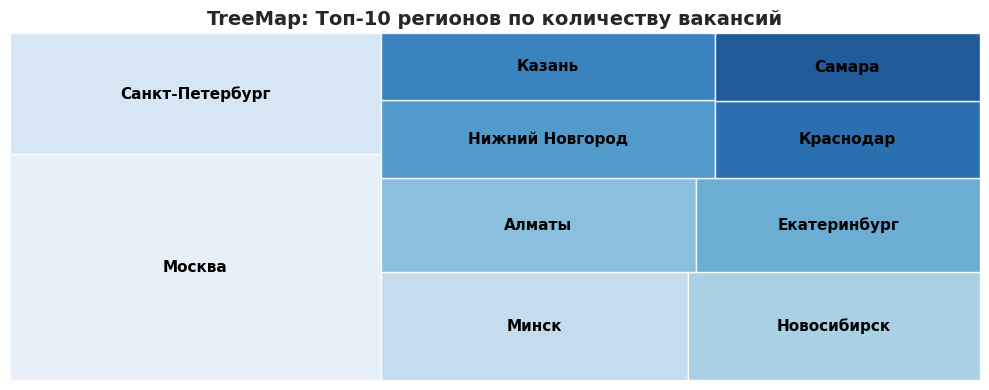

In [ ]:
query = """
SELECT a.name AS region, COUNT(v.id) AS vacancy_count
FROM public.vacancies v
JOIN public.areas a ON v.area_id = a.id
GROUP BY a.name
ORDER BY vacancy_count DESC
LIMIT 10;
"""

df = pd.read_sql_query(query, connection)

# TreeMap
plt.figure(figsize=(10, 4))
squarify.plot(
    sizes=df['vacancy_count'],
    label=df['region'],
    color=sns.color_palette("Blues", len(df)),
    alpha=0.9,
    text_kwargs={'fontsize': 11, 'weight': 'bold', 'color': 'black'}
)
plt.title("TreeMap: Топ-10 регионов по количеству вакансий", fontsize=14, weight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

###Топ-10 сфер деятельности

/tmp/ipython-input-905331790.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


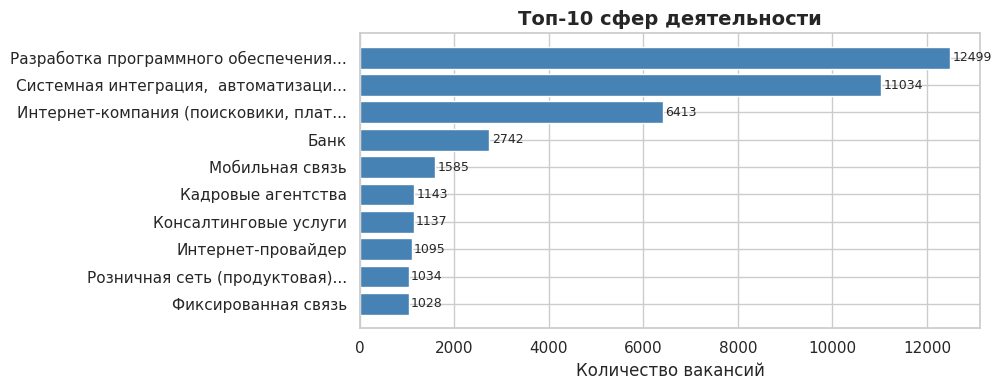

In [ ]:
query = """
SELECT i.name AS industry, COUNT(v.id) AS vacancy_count
FROM public.vacancies v
JOIN public.employers e ON v.employer_id = e.id
JOIN public.employers_industries ei ON e.id = ei.employer_id
JOIN public.industries i ON ei.industry_id = i.id
GROUP BY i.name
ORDER BY vacancy_count DESC
LIMIT 10;
"""

df = pd.read_sql_query(query, connection)

# Обрезаем длинные названия сфер
df['industry_short'] = df['industry'].apply(lambda x: x[:35] + '...' if len(x) > 25 else x)

# Построение графика
plt.figure(figsize=(10, 4))
bars = plt.barh(df['industry_short'][::-1], df['vacancy_count'][::-1], color='steelblue')

plt.title("Топ-10 сфер деятельности", fontsize=14, weight='bold')
plt.xlabel("Количество вакансий")
plt.tight_layout()

# Добавляем значения на столбцы
for bar in bars:
    plt.text(bar.get_width() + 50, bar.get_y() + bar.get_height()/2,
             f'{int(bar.get_width())}', va='center', fontsize=9)

plt.show()

### Соотношение работодателей и вакансий в топ-10 регионах

/tmp/ipython-input-1990664874.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


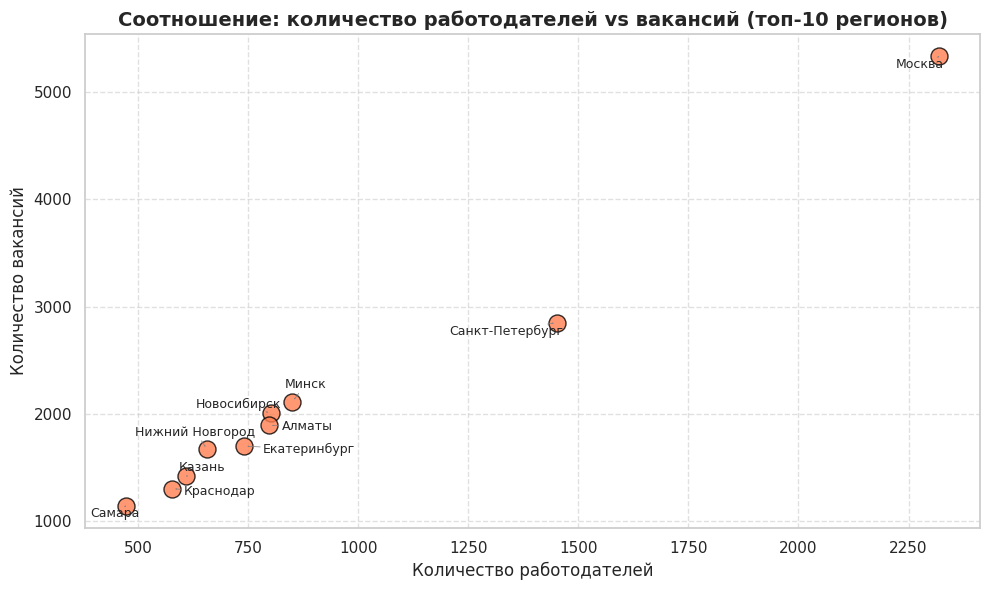

In [ ]:
query = """
SELECT
    a.name AS region,
    COUNT(DISTINCT v.employer_id) AS employer_count,
    COUNT(v.id) AS vacancy_count
FROM public.vacancies v
JOIN public.areas a ON v.area_id = a.id
GROUP BY a.name
ORDER BY vacancy_count DESC
LIMIT 10;
"""

df = pd.read_sql_query(query, connection)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['employer_count'], df['vacancy_count'], s=150, color='coral', alpha=0.8, edgecolors='black')

plt.title("Соотношение: количество работодателей vs вакансий (топ-10 регионов)",
          fontsize=14, weight='bold')
plt.xlabel("Количество работодателей")
plt.ylabel("Количество вакансий")
plt.grid(True, linestyle='--', alpha=0.6)

# список текстовых объектов
texts = []
for i in range(len(df)):
    texts.append(plt.text(df['employer_count'][i], df['vacancy_count'][i],
                          df['region'][i], fontsize=9, ha='center', va='center'))

# перемещаем подписи (без наложений)
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))

plt.tight_layout()
plt.show()

### Запрос: Количество вакансий в каждом регионе

/tmp/ipython-input-2489437007.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


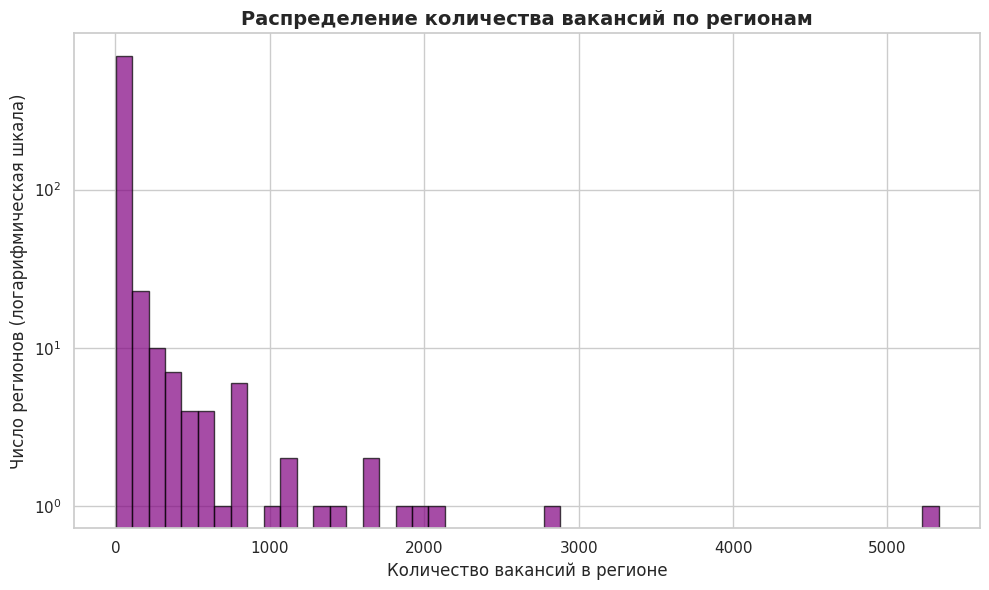

In [ ]:
query = """
SELECT COUNT(v.id) AS vacancy_count
FROM public.vacancies v
JOIN public.areas a ON v.area_id = a.id
GROUP BY a.name;
"""

df = pd.read_sql_query(query, connection)

# Построение гистограммы (с логарифмической осью Y)
plt.figure(figsize=(10, 6))
plt.hist(df['vacancy_count'], bins=50, color='purple', alpha=0.7, edgecolor='black')
plt.yscale('log')  # Логарифмическая шкала по оси Y
plt.title("Распределение количества вакансий по регионам", fontsize=14, weight='bold')
plt.xlabel("Количество вакансий в регионе")
plt.ylabel("Число регионов (логарифмическая шкала)")
plt.tight_layout()
plt.show()

Использована логарифмическая шкала, т.к. распределение неравномерно. У нас большое количество регионов с очень маленьким и несколько -  с очень большим числом вакансий.

#Детальный анализ вакансий

### ТОП-5 регионов по количеству вакансий

In [ ]:
query = """
SELECT
    a.name AS region_name,
    COUNT(v.id) AS vacancy_count
FROM public.vacancies v
JOIN public.areas a ON v.area_id = a.id
GROUP BY a.name
ORDER BY vacancy_count DESC
LIMIT 5;
"""
df_top_regions = pd.read_sql_query(query, connection)
df_top_regions

/tmp/ipython-input-3746795809.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_top_regions = pd.read_sql_query(query, connection)


,region_name,vacancy_count
0,Москва,5333
1,Санкт-Петербург,2851
2,Минск,2112
3,Новосибирск,2006
4,Алматы,1892


/tmp/ipython-input-820151060.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_detailed = pd.read_sql_query(query_detailed, connection, params={'regions': top_5_regions})


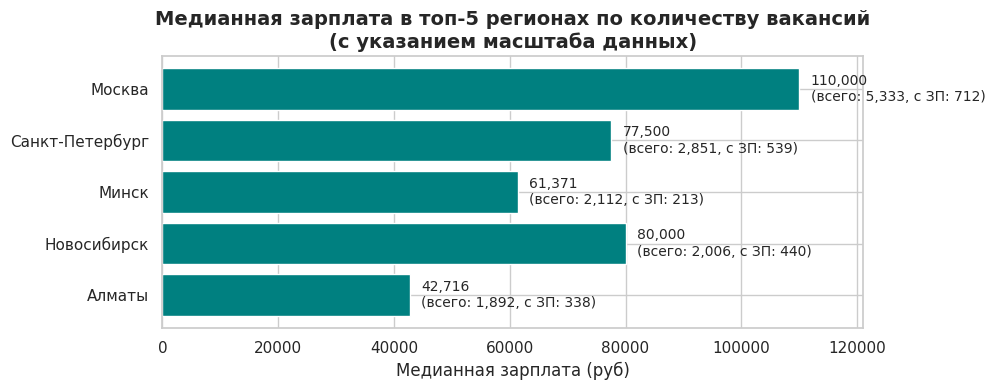

In [ ]:
top_5_regions = tuple(df_top_regions['region_name'].tolist())

# Данные по этим ТОП-регионам: всего вакансий, с зарплатой, медиана
query_detailed = """
SELECT
    a.name AS region,
    COUNT(v.id) AS total_vacancies,
    COUNT(CASE WHEN v.salary_from IS NOT NULL AND v.salary_to IS NOT NULL THEN 1 END) AS vacancies_with_salary,
    PERCENTILE_CONT(0.5) WITHIN GROUP (
        ORDER BY (v.salary_from + v.salary_to) / 2
    ) FILTER (
        WHERE v.salary_from IS NOT NULL AND v.salary_to IS NOT NULL
    ) AS median_salary
FROM public.vacancies v
JOIN public.areas a ON v.area_id = a.id
WHERE a.name IN %(regions)s
GROUP BY a.name
ORDER BY total_vacancies DESC;  -- Сохраняем порядок по популярности
"""

df_detailed = pd.read_sql_query(query_detailed, connection, params={'regions': top_5_regions})

# Удаляем строки, где нет зарплат (median_salary IS NULL)
df_detailed = df_detailed.dropna(subset=['median_salary']).reset_index(drop=True)
# Разворачиваем DataFrame
df_detailed = df_detailed[::-1].reset_index(drop=True)  # ← ЭТО КЛЮЧЕВАЯ СТРОКА!

plt.figure(figsize=(10, 4))
bars = plt.barh(df_detailed['region'], df_detailed['median_salary'], color='teal')
plt.title('Медианная зарплата в топ-5 регионах по количеству вакансий\n(с указанием масштаба данных)',
          fontsize=14, weight='bold')
plt.xlabel('Медианная зарплата (руб)')
plt.xlim(0, df_detailed['median_salary'].max() * 1.1)

# подписи к каждому столбцу
for i, bar in enumerate(bars):
    total = int(df_detailed.loc[i, 'total_vacancies'])
    with_salary = int(df_detailed.loc[i, 'vacancies_with_salary'])
    median = int(df_detailed.loc[i, 'median_salary'])

    # Форматируем подпись: "71 065\n(всего: 12 345, с ЗП: 6 234)"
    label = f"{median:,}\n(всего: {total:,}, с ЗП: {with_salary:,})"

    plt.text(bar.get_width() + 2000,
             bar.get_y() + bar.get_height()/2,
             label,
             va='center',
             fontsize=10,
             fontweight='normal')

plt.tight_layout()
plt.show()

### Количество вакансий, у которых заполнено хотя бы одно поле с зарплатой

In [ ]:
query_salary_count = """
SELECT COUNT(*) AS vacancies_with_salary
FROM public.vacancies
WHERE salary_from IS NOT NULL OR salary_to IS NOT NULL;
"""
df_salary_count = pd.read_sql_query(query_salary_count, connection)
df_salary_count

/tmp/ipython-input-532785618.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_salary_count = pd.read_sql_query(query_salary_count, connection)


,vacancies_with_salary
0,24073


### Средние значения для нижней и верхней границы зарплатной вилки

In [ ]:
query_avg_salary = """
SELECT
    ROUND(AVG(salary_from)) AS avg_salary_from,
    ROUND(AVG(salary_to)) AS avg_salary_to
FROM public.vacancies
WHERE salary_from IS NOT NULL OR salary_to IS NOT NULL;
"""
df_avg_salary = pd.read_sql_query(query_avg_salary, connection)
df_avg_salary

/tmp/ipython-input-2564443091.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_avg_salary = pd.read_sql_query(query_avg_salary, connection)


,avg_salary_from,avg_salary_to
0,71065.0,110537.0


### Количество вакансий для каждого сочетания schedule и employment (вторая по популярности пара)

In [ ]:
query_second_most_popular = """
SELECT
    schedule,
    employment,
    COUNT(*) AS vacancy_count
FROM public.vacancies
GROUP BY schedule, employment
ORDER BY vacancy_count DESC
LIMIT 1 OFFSET 1;
"""
df_second_pair = pd.read_sql_query(query_second_most_popular, connection)
df_second_pair

/tmp/ipython-input-2115025431.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_second_pair = pd.read_sql_query(query_second_most_popular, connection)


,schedule,employment,vacancy_count
0,Удаленная работа,Полная занятость,7802


### «Требуемый опыт работы» (experience) в порядке возрастания количества вакансий

In [ ]:
query_experience = """
SELECT
    experience,
    COUNT(*) AS vacancy_count
FROM public.vacancies
GROUP BY experience
ORDER BY vacancy_count ASC;
"""
df_experience = pd.read_sql_query(query_experience, connection)
df_experience

/tmp/ipython-input-596952697.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_experience = pd.read_sql_query(query_experience, connection)


,experience,vacancy_count
0,Более 6 лет,1337
1,Нет опыта,7197
2,От 3 до 6 лет,14511
3,От 1 года до 3 лет,26152


/tmp/ipython-input-1844869107.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)
/tmp/ipython-input-1844869107.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['schedule_employment'] = df_filtered['schedule'] + ' | ' + df_filtered['employment']


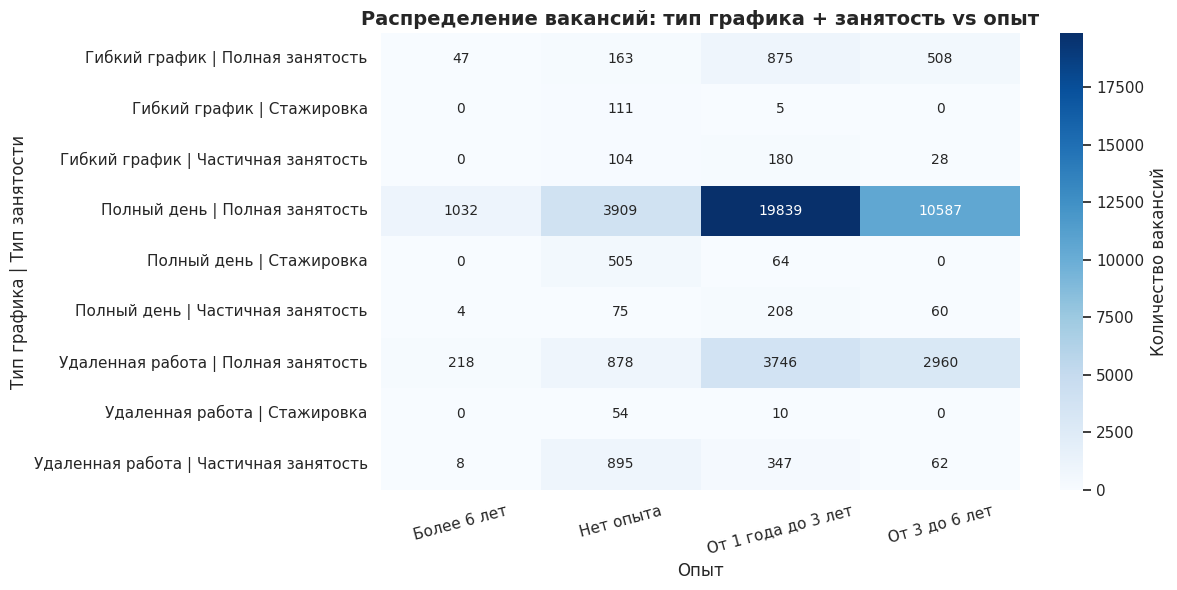

In [ ]:
query = """
SELECT
    schedule,
    employment,
    experience,
    COUNT(*) AS vacancy_count
FROM public.vacancies
WHERE schedule IS NOT NULL
    AND employment IS NOT NULL
    AND experience IS NOT NULL
GROUP BY schedule, employment, experience
ORDER BY vacancy_count DESC;
"""

df = pd.read_sql_query(query, connection)

# Фильтруем топ-5 по каждому измерению (чтобы не перегружать график)
top_schedules = df.groupby('schedule')['vacancy_count'].sum().nlargest(3).index
top_employments = df.groupby('employment')['vacancy_count'].sum().nlargest(3).index
top_experiences = ['Нет опыта', 'От 1 года до 3 лет', 'От 3 до 6 лет', 'Более 6 лет']

df_filtered = df[
    (df['schedule'].isin(top_schedules)) &
    (df['employment'].isin(top_employments)) &
    (df['experience'].isin(top_experiences))
]

# Создаем составной индекс: schedule | employment
df_filtered['schedule_employment'] = df_filtered['schedule'] + ' | ' + df_filtered['employment']

# Построение тепловой карты
plt.figure(figsize=(12, 6))
pivot = df_filtered.pivot_table(
    index='schedule_employment',
    columns='experience',
    values='vacancy_count',
    fill_value=0
)

sns.heatmap(pivot, annot=True, fmt='g', cmap='Blues', cbar_kws={'label': 'Количество вакансий'})
plt.title('Распределение вакансий: тип графика + занятость vs опыт', fontsize=14, weight='bold')
plt.xlabel('Опыт')
plt.ylabel('Тип графика | Тип занятости')
plt.xticks(rotation=15)
plt.yticks(rotation=0)  # Чтобы подписи на оси Y были читаемыми
plt.tight_layout()
plt.show()

/tmp/ipython-input-3914579085.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)
/tmp/ipython-input-3914579085.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top['industry_short'] = df_top['industry'].apply(lambda x: x[:30] + '...' if len(x) > 25 else x)


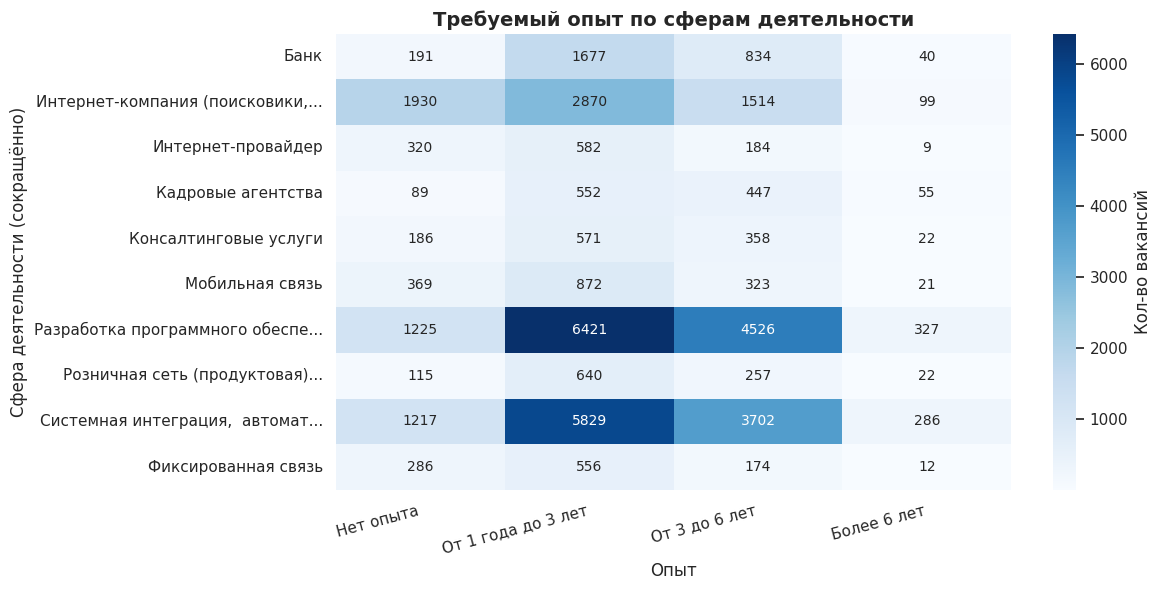

In [ ]:
# Требуемый опыт по сферам деятельности ТОП-10
query = """
SELECT
    i.name AS industry,
    v.experience,
    COUNT(v.id) AS vacancy_count
FROM public.vacancies v
JOIN public.employers e ON v.employer_id = e.id
JOIN public.employers_industries ei ON e.id = ei.employer_id
JOIN public.industries i ON ei.industry_id = i.id
WHERE v.experience IS NOT NULL
GROUP BY i.name, v.experience
ORDER BY vacancy_count DESC;
"""

df = pd.read_sql_query(query, connection)

# Берём топ-10 сфер
top_industries = df.groupby('industry')['vacancy_count'].sum().nlargest(10).index
df_top = df[df['industry'].isin(top_industries)]

# Обрезаем названия сфер
df_top['industry_short'] = df_top['industry'].apply(lambda x: x[:30] + '...' if len(x) > 25 else x)

# Сводная таблица
pivot = df_top.pivot_table(
    index='industry_short',  # ← используем короткие названия
    columns='experience',
    values='vacancy_count',
    fill_value=0
)

# Сортируем опыт в логическом порядке
experience_order = ['Нет опыта', 'От 1 года до 3 лет', 'От 3 до 6 лет', 'Более 6 лет']
pivot = pivot.reindex(columns=experience_order, fill_value=0)


plt.figure(figsize=(12, 6))
sns.heatmap(pivot, annot=True, fmt='g', cmap='Blues', cbar_kws={'label': 'Кол-во вакансий'})

plt.title('Требуемый опыт по сферам деятельности', fontsize=14, weight='bold')
plt.ylabel('Сфера деятельности (сокращённо)')
plt.xlabel('Опыт')

# Поворачиваем подписи на оси X для лучшей читаемости
plt.xticks(rotation=15, ha='right')

plt.tight_layout()
plt.show()

Анализ подтверждает существуюбщий тезис, что рынок труда по прежнему ориентирован на опытных специалистов, концентрирован в крупных городах и активно переходит на удалённую работу (2 по популярности пара полная занятость - удаленный формат работы).

При этом данные о ЗП (хотя бы одна граница) указаны в 49% вакансий (24 073 из 49 197). Это говорит о нежелании работодателя раскрывать информацию о ЗП и непрозрачности зарплатного рынка. Это усложняет проведение переговоров соискателями и создает дополнительные преимущества для работодателей.

Высокая концентрация вакансий (в рассматриваемых сферах деятельности) представлена в мегаполисах (Москва, Санкт-Петербург, Минск и др.) Это подтверждает тенденцию урбанизации рынка труда: основной спрос на персонал формируется в крупных экономических центрах.

#Анализ работодателей

### Какие работодатели находятся на первом и пятом месте по количеству вакансий.

In [ ]:
query_top_employers = """
SELECT
    e.name AS employer_name,
    COUNT(v.id) AS vacancy_count
FROM public.vacancies v
JOIN public.employers e ON v.employer_id = e.id
GROUP BY e.name
ORDER BY vacancy_count DESC
LIMIT 5;
"""

df_top_employers = pd.read_sql_query(query_top_employers, connection)
df_top_employers

/tmp/ipython-input-1265213656.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_top_employers = pd.read_sql_query(query_top_employers, connection)


,employer_name,vacancy_count
0,Яндекс,1933
1,Ростелеком,491
2,Тинькофф,444
3,СБЕР,428
4,Газпром нефть,331


### Соотношение количества работодателей и вакансий по регионам

In [ ]:
query_all_regions = """
SELECT
    a.name AS region,
    COUNT(e.id) AS employer_count,        -- работодатели напрямую из employers
    COUNT(v.id) AS vacancy_count          -- вакансии из vacancies
FROM public.areas a
LEFT JOIN public.employers e ON a.id = e.area      -- прямая связь!
LEFT JOIN public.vacancies v ON a.id = v.area_id   -- вакансии по региону
GROUP BY a.name;
"""

df_all_regions = pd.read_sql_query(query_all_regions, connection)

# ТОП-10 регионов по количеству работодателей
print("ТОП-10 регионов по количеству работодателей:")
display(df_all_regions.nlargest(10, 'employer_count'))

# Фильтр: регионы без вакансий, но с работодателями
df_no_vacancies = df_all_regions[
    (df_all_regions['vacancy_count'] == 0) &
    (df_all_regions['employer_count'] > 0)
]

# регион с максимальным числом работодателей
if not df_no_vacancies.empty:
    answer_region = df_no_vacancies.nlargest(1, 'employer_count').iloc[0]['region']
    print(f"\nРегион без вакансий с максимальным числом работодателей: {answer_region}")
else:
    print("\nНет регионов без вакансий, но с работодателями")

/tmp/ipython-input-420167344.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_all_regions = pd.read_sql_query(query_all_regions, connection)


ТОП-10 регионов по количеству работодателей:


,region,employer_count,vacancy_count
233,Москва,31272712,31272712
314,Санкт-Петербург,6320667,6320667
1337,Минск,2354880,2354880
257,Алматы,1364132,1364132
1183,Новосибирск,1149438,1149438
450,Екатеринбург,1034082,1034082
351,Нижний Новгород,711420,711420
172,Казань,679200,679200
738,Краснодар,532109,532109
196,Ростов-на-Дону,378885,378885



Регион без вакансий с максимальным числом работодателей: Россия


In [ ]:
query_all_regions = """
SELECT
    a.name AS region,
    COUNT(DISTINCT v.employer_id) AS employer_count,
    COUNT(v.id) AS vacancy_count
FROM public.areas a
LEFT JOIN public.vacancies v ON a.id = v.area_id
GROUP BY a.name;
"""

# Сохраняем результат в датафрейм
df_all_regions = pd.read_sql_query(query_all_regions, connection)

# Выводим ТОП-10 регионов по количеству работодателей
print("ТОП-10 регионов по количеству работодателей:")
display(df_all_regions.nlargest(10, 'employer_count'))

/tmp/ipython-input-315576586.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_all_regions = pd.read_sql_query(query_all_regions, connection)


ТОП-10 регионов по количеству работодателей:


,region,employer_count,vacancy_count
728,Москва,2320,5333
1012,Санкт-Петербург,1451,2851
705,Минск,851,2112
802,Новосибирск,802,2006
32,Алматы,798,1892
339,Екатеринбург,742,1698
776,Нижний Новгород,657,1670
441,Казань,609,1415
573,Краснодар,578,1301
989,Ростов-на-Дону,487,1131


### Распределение работодателей по регионам

/tmp/ipython-input-4007837427.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


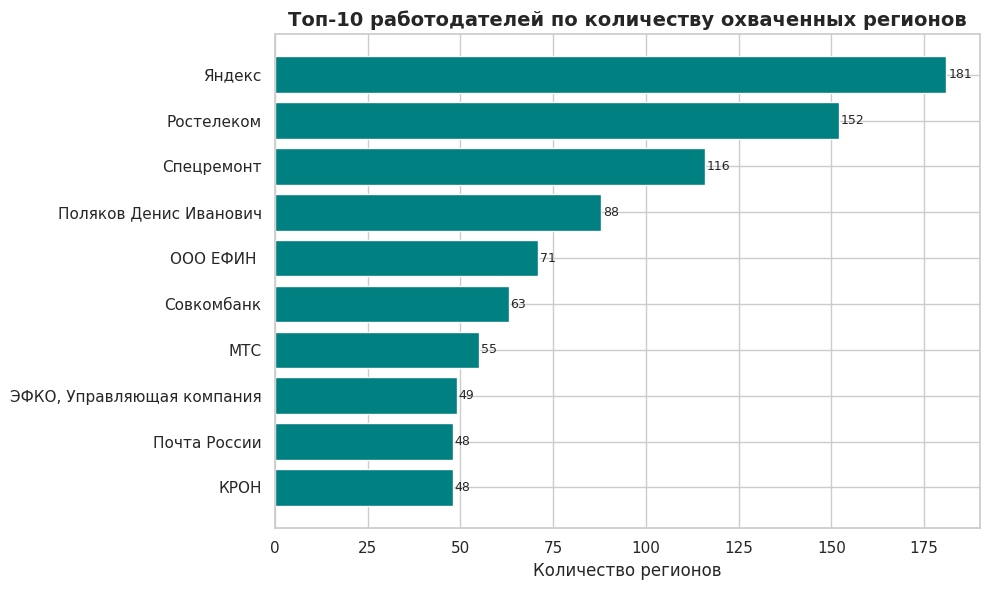

In [ ]:
query = """
SELECT
    e.name AS employer_name,
    COUNT(DISTINCT v.area_id) AS region_count
FROM public.vacancies v
JOIN public.employers e ON v.employer_id = e.id
GROUP BY e.name
ORDER BY region_count DESC
LIMIT 10;
"""

df = pd.read_sql_query(query, connection)

plt.figure(figsize=(10, 6))
bars = plt.barh(df['employer_name'][::-1], df['region_count'][::-1], color='teal')
plt.title('Топ-10 работодателей по количеству охваченных регионов', fontsize=14, weight='bold')
plt.xlabel('Количество регионов')

for bar in bars:
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
             f'{int(bar.get_width())}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

Максимальный охват вакансиями регионов (181) у компании Яндекс

/tmp/ipython-input-3269013025.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


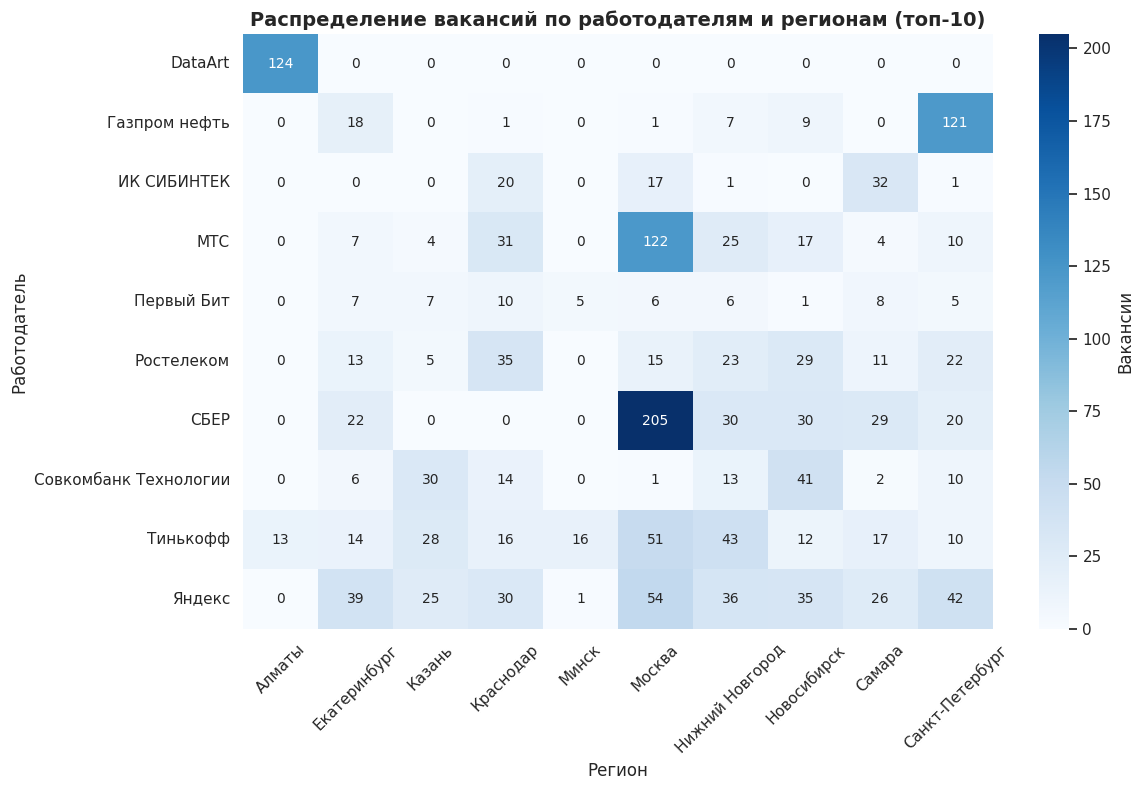

In [ ]:
query = """
SELECT
    a.name AS region,
    e.name AS employer_name,
    COUNT(v.id) AS vacancy_count
FROM public.vacancies v
JOIN public.employers e ON v.employer_id = e.id
JOIN public.areas a ON v.area_id = a.id
GROUP BY a.name, e.name
ORDER BY vacancy_count DESC;
"""

df = pd.read_sql_query(query, connection)

# Берём топ-10 регионов и топ-10 работодателей
top_regions = df.groupby('region')['vacancy_count'].sum().nlargest(10).index
top_employers = df.groupby('employer_name')['vacancy_count'].sum().nlargest(10).index

df_filtered = df[
    (df['region'].isin(top_regions)) &
    (df['employer_name'].isin(top_employers))
]

pivot = df_filtered.pivot_table(
    index='employer_name',
    columns='region',
    values='vacancy_count',
    fill_value=0
)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot, annot=True, fmt='g', cmap='Blues', cbar_kws={'label': 'Вакансии'})
plt.title('Распределение вакансий по работодателям и регионам (топ-10)', fontsize=14, weight='bold')
plt.ylabel('Работодатель')
plt.xlabel('Регион')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Cферы деятельности работодателей.

In [ ]:
# Подсчёт количества работодателей, у которых не указана сфера деятельности.
query_no_industry = """
SELECT COUNT(*) AS no_industry_count
FROM public.employers e
LEFT JOIN public.employers_industries ei ON e.id = ei.employer_id
WHERE ei.industry_id IS NULL;
"""

df_no_industry = pd.read_sql_query(query_no_industry, connection)
no_industry_count = int(df_no_industry.iloc[0]['no_industry_count'])
no_industry_count

/tmp/ipython-input-1333482387.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_no_industry = pd.read_sql_query(query_no_industry, connection)


8419

In [ ]:
# Компании с 4 сферами деятельности, отсортированные по алфавиту
query_four_industries = """
SELECT
    e.name AS employer_name
FROM public.employers e
JOIN public.employers_industries ei ON e.id = ei.employer_id
GROUP BY e.name
HAVING COUNT(ei.industry_id) = 4
ORDER BY e.name ASC
LIMIT 1 OFFSET 2;  -- Третье место (индекс 2)
"""

df_third_company = pd.read_sql_query(query_four_industries, connection)
third_company_name = df_third_company.iloc[0]['employer_name']
third_company_name

/tmp/ipython-input-2775946132.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_third_company = pd.read_sql_query(query_four_industries, connection)


'2ГИС'

In [ ]:
# Количество работодателей с сферой "Разработка программного обеспечения"
query_dev_software = """
SELECT COUNT(DISTINCT e.id) AS dev_software_count
FROM public.employers e
JOIN public.employers_industries ei ON e.id = ei.employer_id
JOIN public.industries i ON ei.industry_id = i.id
WHERE i.name = 'Разработка программного обеспечения';
"""

df_dev_software = pd.read_sql_query(query_dev_software, connection)
dev_software_count = int(df_dev_software.iloc[0]['dev_software_count'])
dev_software_count

/tmp/ipython-input-130290707.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_dev_software = pd.read_sql_query(query_dev_software, connection)


3553

/tmp/ipython-input-2380109363.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


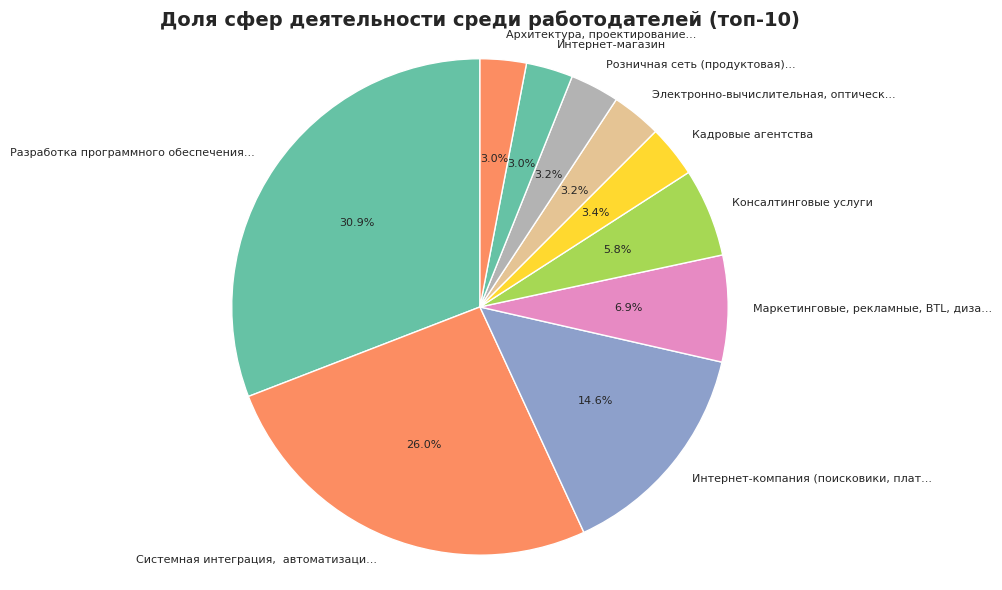

In [ ]:
# Доля сфер деятельности среди работодателей (топ-10)
query = """
SELECT
    i.name AS industry,
    COUNT(*) AS employer_count
FROM public.employers e
JOIN public.employers_industries ei ON e.id = ei.employer_id
JOIN public.industries i ON ei.industry_id = i.id
GROUP BY i.name
ORDER BY employer_count DESC
LIMIT 10;
"""

df = pd.read_sql_query(query, connection)

# Обрезаем длинные названия
df['industry_short'] = df['industry'].apply(lambda x: x[:35] + '...' if len(x) > 25 else x)

# Построение графика
plt.figure(figsize=(10, 6))

# Уменьшаем шрифт подписей и процентов
wedges, texts, autotexts = plt.pie(
    df['employer_count'],
    labels=df['industry_short'],
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette("Set2"),
    textprops={'fontsize': 8}
)

plt.title('Доля сфер деятельности среди работодателей (топ-10)', fontsize=14, weight='bold')
plt.axis('equal')

plt.tight_layout()
plt.show()

In [ ]:
# Список городов-миллионников + Саратов и Тюмень (всего 18 городов)
million_cities = [
    'Москва', 'Санкт-Петербург', 'Новосибирск', 'Екатеринбург', 'Казань',
    'Красноярск', 'Нижний Новгород', 'Челябинск', 'Уфа', 'Краснодар',
    'Самара', 'Ростов-на-Дону', 'Омск', 'Воронеж', 'Пермь', 'Волгоград'
]

# Запрос: вакансии компании "Яндекс" в указанных городах
query_yandex = f"""
SELECT
    a.name AS name,
    COUNT(v.id) AS cnt
FROM public.vacancies v
JOIN public.employers e ON v.employer_id = e.id
JOIN public.areas a ON v.area_id = a.id
WHERE e.name = 'Яндекс'
    AND a.name IN {tuple(million_cities)}
GROUP BY a.name
ORDER BY cnt DESC;
"""

df_yandex = pd.read_sql_query(query_yandex, connection)

# Добавляем строку "Total"
total_row = pd.DataFrame([['Total', df_yandex['cnt'].sum()]], columns=['name', 'cnt'])
df_result = pd.concat([df_yandex, total_row], ignore_index=True)

df_result

/tmp/ipython-input-3219859179.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_yandex = pd.read_sql_query(query_yandex, connection)


,name,cnt
0,Москва,54
1,Санкт-Петербург,42
2,Екатеринбург,39
3,Нижний Новгород,36
4,Новосибирск,35
5,Воронеж,32
6,Краснодар,30
7,Самара,26
8,Уфа,26
9,Казань,25


Рынок труда формируют крупные компании («Яндекс», «Сбер», «МТС», «Газпром нефть» и др.). Крупнейшие работодатели работают на федеральном уровне, максимальных охват регионов одной компанием - 181 регион по всей стране.

Проблемы с прозрачностью предоставляемой работодателем информации. У 8 419 работодателей не указана сфера деятельности (почти половина всех компаний в базе) Это затрудняет отраслевой анализ и снижает прозрачность рынка труда.

Самая крупная отрасль (из тех, что были указаны) - 3 553 работодателей связаны с «Разработкой программного обеспечения»

Наблюдается тиенденция к диверсификации бизнеса. Компании могут принадлежать сразу к нескольким сферам. Например, «2ГИС» указан в четырёх отраслях одновременно. Это может вызвать сложности при классификации компаний по одной категории.

Рынок труда характеризуется высокой концентрацией предложения работы в мегополисах.

Таким образом, в рассматриваемых данных можно сделать вывод, что на рынке труда доминируют крупные работодатели с концентрацией в крупных гоордах. При этом есть существенная проблема с прозрачностью предоставляемых соискателям данных (отрасть, ЗП)

#Предметный анализ

### Количество вакансий, связанных с данными

In [ ]:
query_data_vacancies = """
SELECT COUNT(*) AS data_vacancies
FROM public.vacancies
WHERE LOWER(name) LIKE '%data%'
   OR LOWER(name) LIKE '%данн%';
"""
df_data = pd.read_sql_query(query_data_vacancies, connection)
df_data.iloc[0]['data_vacancies']

/tmp/ipython-input-174613620.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_data = pd.read_sql_query(query_data_vacancies, connection)


np.int64(1771)

### Количество вакансий для Junior data-сайентиста

In [ ]:
query_junior_data = """
SELECT COUNT(*) AS junior_data_vacancies
FROM public.vacancies
WHERE (
    name ILIKE '%data scientist%'
    OR name ILIKE '%data science%'
    OR name ILIKE '%исследователь данных%'
    OR name ILIKE '%machine learning%'
    OR name ILIKE '%машин%обучен%'
    OR name ~* '(^|[^a-zA-Z0-??9])ml([^a-zA-Z0-9]|$)'  -- только "ml"
)
AND (
    name ILIKE '%junior%'
    OR experience = 'Нет опыта'
    OR employment = 'Стажировка'
);
"""

df_junior = pd.read_sql_query(query_junior_data, connection)
df_junior.iloc[0]['junior_data_vacancies']

/tmp/ipython-input-3463245450.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_junior = pd.read_sql_query(query_junior_data, connection)


np.int64(51)

### Количество вакансий для DS с навыком SQL или Postgres

In [ ]:
query_sql_postgres = """
SELECT COUNT(*) AS sql_postgres_count
FROM public.vacancies
WHERE (
    name ILIKE '%data scientist%'
    OR name ILIKE '%data science%'
    OR name ILIKE '%исследователь данных%'
    OR name ILIKE '%machine learning%'
    OR name ~* '(^|[^a-zA-Z0-9])ml([^a-zA-Z0-9]|$)'
    OR name ILIKE '%машин%обучен%'
)
AND (
    key_skills ILIKE '%sql%'
    OR key_skills ILIKE '%postgres%'
    OR key_skills ILIKE '%postgresql%'
);
"""

df_sql = pd.read_sql_query(query_sql_postgres, connection)
df_sql.iloc[0]['sql_postgres_count']

/tmp/ipython-input-7123537.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sql = pd.read_sql_query(query_sql_postgres, connection)


np.int64(195)

### Количество вакансий для DS с навыком Python

In [ ]:
query_python = """
SELECT COUNT(*) AS python_count
FROM public.vacancies
WHERE (
    name ILIKE '%data scientist%'
    OR name ILIKE '%data science%'
    OR name ILIKE '%исследователь данных%'
    OR name ILIKE '%ML%'
    OR name ILIKE '%machine learning%'
    OR name ILIKE '%машин%обучен%'  -- исправлена опечатка
)
AND key_skills ILIKE '%python%';
"""

df_python = pd.read_sql_query(query_python, connection)
df_python.iloc[0]['python_count']

/tmp/ipython-input-395301087.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_python = pd.read_sql_query(query_python, connection)


np.int64(357)

### Запрос: среднее количество ключевых навыков в вакансиях для DS

In [ ]:
query_grouped = """
SELECT
    id,
    STRING_AGG(key_skills, ', ') AS all_skills
FROM public.vacancies
WHERE (LOWER(name) LIKE '%data%' OR LOWER(name) LIKE '%данн%')
  AND key_skills IS NOT NULL
GROUP BY id;
"""

df_grouped = pd.read_sql_query(query_grouped, connection)

def count_skills_grouped(skill_str):
    if pd.isna(skill_str):
        return 0
    parts = skill_str.split(',')
    parts = [p.strip() for p in parts if p.strip()]
    return len(parts)

df_grouped['skill_count'] = df_grouped['all_skills'].apply(count_skills_grouped)
avg_skills_correct = df_grouped['skill_count'].mean()
print("Правильное среднее количество навыков:", round(avg_skills_correct, 2))

/tmp/ipython-input-1734772854.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_grouped = pd.read_sql_query(query_grouped, connection)


Правильное среднее количество навыков: 1.04


### Cредняя зарплата по опыту для DS

In [ ]:
query_avg_salary_by_exp = """
SELECT
    ROUND(AVG(
        CASE
            WHEN salary_from IS NOT NULL AND salary_to IS NOT NULL THEN (salary_from + salary_to) / 2.0
            WHEN salary_from IS NOT NULL THEN salary_from
            WHEN salary_to IS NOT NULL THEN salary_to
        END
    )) AS avg_salary
FROM public.vacancies
WHERE (
    LOWER(name) LIKE '%data%'
    OR LOWER(name) LIKE '%данн%'
)
AND experience = 'От 3 до 6 лет'
AND (salary_from IS NOT NULL OR salary_to IS NOT NULL);
"""

df_salary = pd.read_sql_query(query_avg_salary_by_exp, connection)
avg_salary = int(df_salary.iloc[0]['avg_salary'])
avg_salary

/tmp/ipython-input-2472877654.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_salary = pd.read_sql_query(query_avg_salary_by_exp, connection)


185184

Всего 1771 вакансия имеет отношение к данным, из них - 51 для начинающих (Junior). Возможности есть, но рынок по прежнему предпочитает нанимать готовых специалистов, а не выращивать самостоятельно.

357 вакансий (более 20%) требуют от соискателя знание Python — это более 20% от всех DS-вакансий. Это пожтверждает тренд на востребованность языка для большинства задач ML и анализа.

229 вакансий требуют SQL или Postgres и это примерно 64% от числа вакансий с Python. Это означает, что не все DS-роли связаны с базами данных, хотя этот навык остается одним из ключевых.

Зарплата растёт с опытом - это подтверждает завичимость, что опыт напрямую влияет на доход

/tmp/ipython-input-3925235754.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_avg_salary = pd.read_sql_query(query_avg_salary_by_exp, connection)


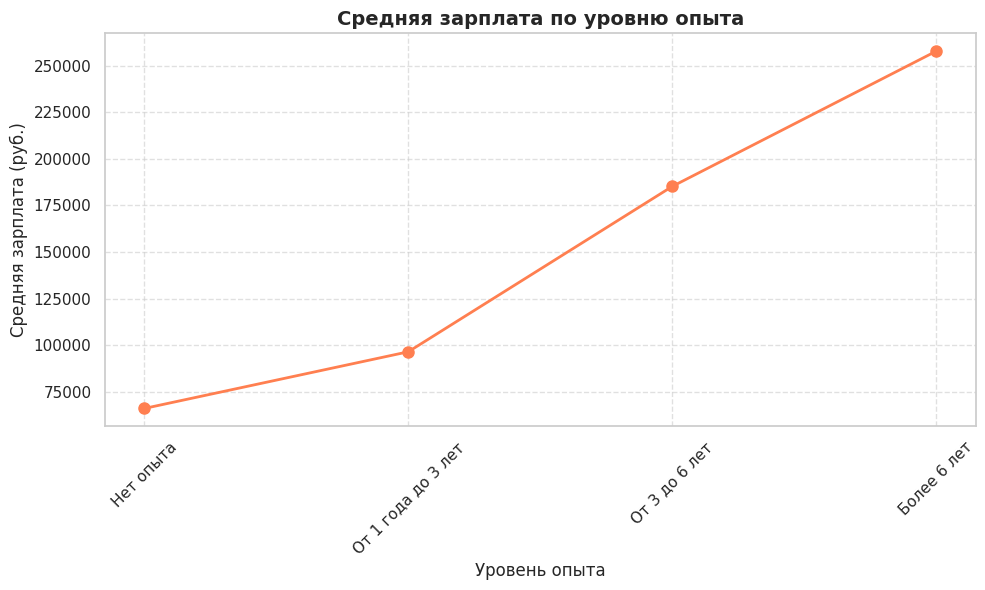

In [ ]:
# Группируем по опыту и считаем среднюю зарплату
query_avg_salary_by_exp = """
SELECT
    experience,
    ROUND(AVG(
        CASE
            WHEN salary_from IS NOT NULL AND salary_to IS NOT NULL THEN (salary_from + salary_to) / 2.0
            WHEN salary_from IS NOT NULL THEN salary_from
            WHEN salary_to IS NOT NULL THEN salary_to
        END
    )) AS avg_salary
FROM public.vacancies
WHERE LOWER(name) LIKE '%data%' OR LOWER(name) LIKE '%данн%'
AND (salary_from IS NOT NULL OR salary_to IS NOT NULL)
GROUP BY experience
ORDER BY
    CASE experience
        WHEN 'Нет опыта' THEN 1
        WHEN 'От 1 года до 3 лет' THEN 2
        WHEN 'От 3 до 6 лет' THEN 3
        WHEN 'Более 6 лет' THEN 4
    END;
"""

df_avg_salary = pd.read_sql_query(query_avg_salary_by_exp, connection)

plt.figure(figsize=(10, 6))
plt.plot(df_avg_salary['experience'], df_avg_salary['avg_salary'], marker='o', linewidth=2, markersize=8, color='coral')
plt.title('Средняя зарплата по уровню опыта', fontsize=14, weight='bold')
plt.xlabel('Уровень опыта')
plt.ylabel('Средняя зарплата (руб.)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipython-input-1913433709.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_skills_raw = pd.read_sql_query(query_all_skills, connection)


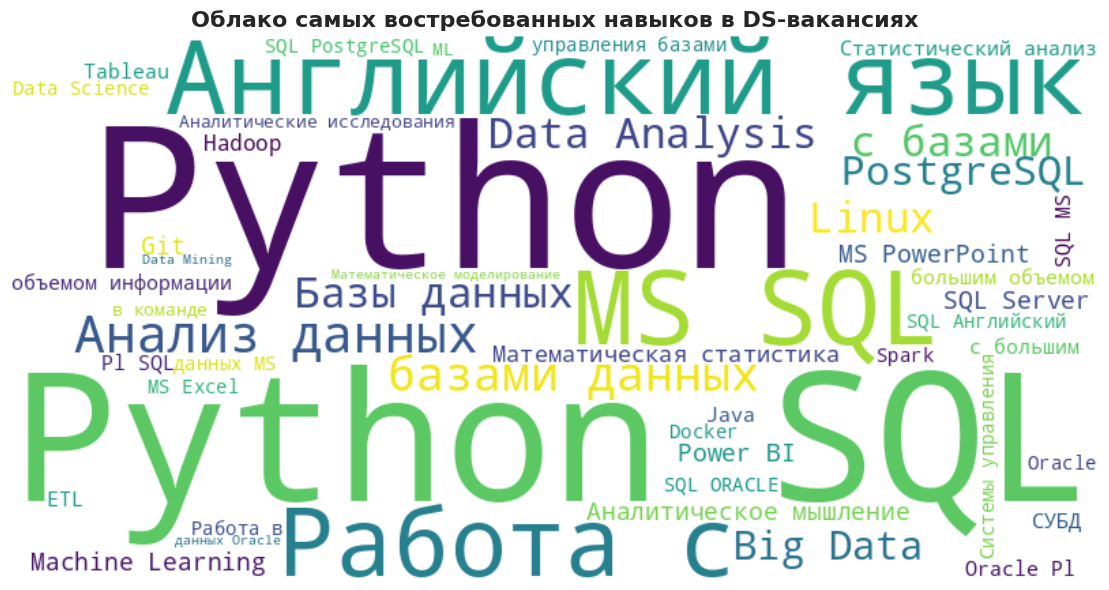

In [ ]:
from wordcloud import WordCloud

# Получаем все навыки
query_all_skills = """
SELECT key_skills
FROM public.vacancies
WHERE (LOWER(name) LIKE '%data%' OR LOWER(name) LIKE '%данн%')
  AND key_skills IS NOT NULL;
"""

df_skills_raw = pd.read_sql_query(query_all_skills, connection)

# Объединяем все навыки в одну строку
all_skills_text = ', '.join(df_skills_raw['key_skills'].dropna().tolist())

# Создаём облако слов
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis',
                      max_words=50, relative_scaling=0.5).generate(all_skills_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако самых востребованных навыков в DS-вакансиях', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

### Финал

In [ ]:
# не забываем закрыть соединение после окончания работы
connection.close()

Данный анализ позволяет понять структуру рынка труда в сфере IT/DS, выявить ключевые тренды, потребности работодателей и возможности для соискателей.

Возможности для соискателя:  
- понять, какие навыки востребованы  
- где искать работу  
- какую зарплату ожидать

Возможности для работодателя:  
- оценить конкуренцию  
- определить, какие регионы и отрасли наиболее перспективны

Основное направление исследования и проверяемая гипотеза:  
"Рынок труда для data-сайентистов характеризуется высокой концентрацией в мегаполисах, доминированием Python как основного языка программирования и ростом требований к опыту работы" — подтверждена.

Также анализ выявил ряд системных проблем, связанных с прозрачностью данных, публикуемых работодателем (отсутствие данных — ЗП, отрасль). При значительном количестве таких пропусков это не выглядит как случайность, а как закономерность и один из приемов получить преимущество и возможность для манёвра на этапе переговоров за счет неполного информирования.

Дальнейшие перспективные направления анализа:  
- Анализ временных трендов (при условии наличия даты публикации вакансии и наличия в базе закрытых вакансий) — изменения ЗП, спроса на отдельных специалистов, изменения географии спроса на специалистов.  
- Выявление корреляций между отдельными навыками и влияние ключевых параметров вакансий (ЗП, требования к опыту, формат работы).